In [1]:
%loadlibs
import deepwave as dw

Loaded libraries:
	- numpy (np)
	- matplotlib.pyplot (plt)
	- torch
	- torch.nn (nn)
	- torch.optim (optim)
	- tqdm


In [39]:
device = 'mps'

In [40]:
nx = 128
ny = 32
dx = 5.

vp_background = torch.ones(ny, nx, device=device) * 1500
vs_background = torch.ones(ny, nx, device=device) * 1000
rho_background = torch.ones(ny, nx, device=device) * 2200

In [41]:
vp_true = vp_background.clone()
vp_true[10:20, 30:40] = 1600
vs_true = vs_background.clone()
vs_true[10:20, 45:55] = 1100
rho_true = rho_background.clone()
rho_true[10:20, 60:70] = 2300

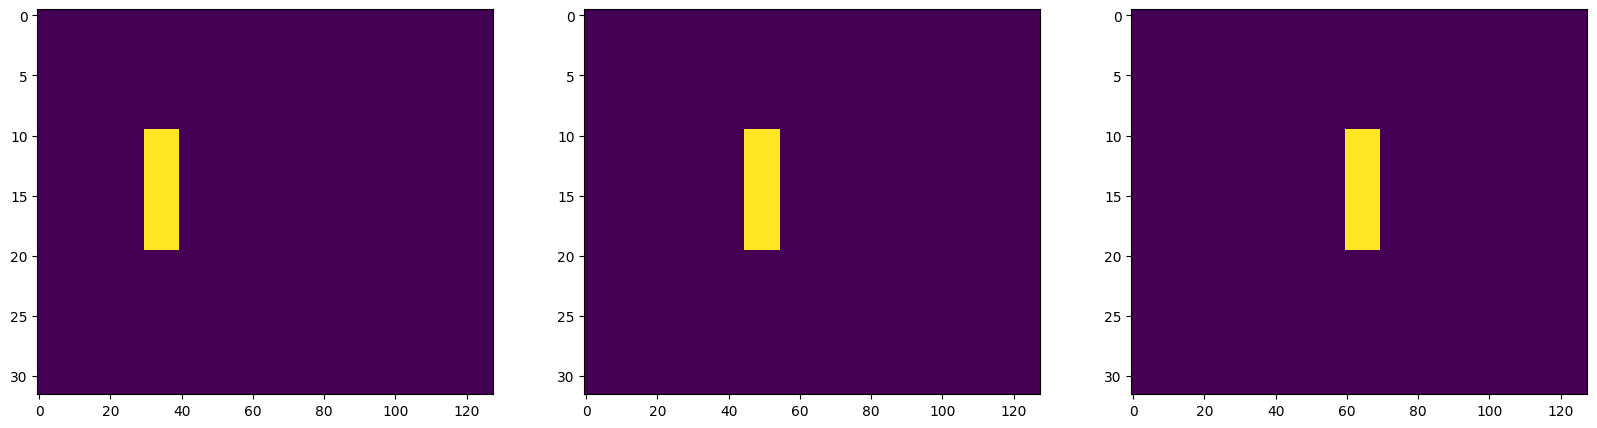

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(vp_true.cpu(), aspect='auto')
ax[1].imshow(vs_true.cpu(), aspect='auto')
ax[2].imshow(rho_true.cpu(), aspect='auto')
plt.show()

In [43]:
n_shots = 2
n_sources_per_shot = 1
d_source = nx//3 
first_source = 15
source_depth = 1

n_receivers_per_shot = nx-1
d_receiver = 1
first_receiver = 0
receiver_depth = 1

In [44]:
freq = 15
nt = 200
dt = 0.04
peak_time = 1.5 / freq

In [45]:
source_locations = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.float32, device=device)
source_locations[..., 0] = source_depth
source_locations[:, 0, 1] = (torch.arange(n_shots) * d_source + first_source)

In [46]:
receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.float32, device=device)
receiver_locations[..., 0] = receiver_depth
receiver_locations[:, :, 1] = (torch.arange(n_receivers_per_shot) * d_receiver + first_receiver).repeat(n_shots, 1)

In [47]:
source_amplitudes = (dw.wavelets.ricker(freq, nt, dt, peak_time)).repeat(n_shots, n_sources_per_shot, 1).to(device)

In [ ]:
observed_data = dw.elastic(*dw.common.vpvsrho_to_lambmubuoyancy(vp_true, vs_true, rho_true), dx, dt,
                        source_amplitudes_y=source_amplitudes,
                        source_locations_y=source_locations,
                        receiver_locations_y=receiver_locations,
                        pml_width=[0, 20, 20, 20]
)[-2]

In [38]:
vp = vp_background.clone().requires_grad_()
vs = vs_background.clone().requires_grad_()
rho = rho_background.clone().requires_grad_()
optimiser = optim.LBFGS([vp, vs, rho])
loss_fn = nn.MSELoss()

n_epochs = 20

for epoch in tqdm(range(n_epochs)):
    def closure():
        optimiser.zero_grad()
        out = dw.elastic(
            *dw.common.vpvsrho_to_lambmubuoyancy(vp, vs, rho),
            dx, dt,
            source_amplitudes_y=source_amplitudes,
            source_locations_y=source_locations,
            receiver_locations_y=receiver_locations,
            pml_width=[0, 20, 20, 20]
        )[-2]
        loss = 1e20*loss_fn(out, observed_data)
        loss.backward()
        return loss

    optimiser.step(closure)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 